In [1]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A

import albumentations.pytorch

import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

#import functools

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    

# Load data

# Visualize the data

Create functions to make a mask based on annotations given in train.csv file

# DataSets

In [5]:
from os.path import join
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

In [6]:
DATA_PATH = './sartorius-cell-instance-segmentation'
SAMPLE_SUBMISSION = join(DATA_PATH,'train')
TRAIN_CSV = join(DATA_PATH,'train.csv')
TRAIN_PATH = join(DATA_PATH,'train')
TEST_PATH = join(DATA_PATH,'test')

df_train = pd.read_csv(TRAIN_CSV)
print(f'Training Set Shape: {df_train.shape} - {df_train["id"].nunique()} \
Images - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (73585, 9) - 606 Images - Memory Usage: 5.05 MB


In [7]:


def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return np.array(mask)



In [8]:
class CellDataset(Dataset):
    def __init__(self, df: pd.core.frame.DataFrame, train:bool):
        self.IMAGE_RESIZE = (224, 224)
        self.RESNET_MEAN = (0.485, 0.456, 0.406)
        self.RESNET_STD = (0.229, 0.224, 0.225)
        self.df = df
        self.base_path = TRAIN_PATH
        self.gb = self.df.groupby('id')
        self.transforms = Compose([Resize( self.IMAGE_RESIZE[0],  self.IMAGE_RESIZE[1]), 
                                   Normalize(mean=self.RESNET_MEAN, std= self.RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5)])
        
        # Split train and val set
        all_image_ids = np.array(df_train.id.unique())
        np.random.seed(42)
        iperm = np.random.permutation(len(all_image_ids))
        num_train_samples = int(len(all_image_ids) * 0.9)

        if train:
            self.image_ids = all_image_ids[iperm[:num_train_samples]]
        else:
             self.image_ids = all_image_ids[iperm[num_train_samples:]]

    def __getitem__(self, idx: int) -> dict:

        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)

        # Read image
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)

        # Create the mask
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        # print(np.moveaxis(image,0,2).shape)
        return np.moveaxis(np.array(image),2,0), mask.reshape((1, self.IMAGE_RESIZE[0], self.IMAGE_RESIZE[1]))


    def __len__(self):
        return len(self.image_ids)

In [9]:
ds_train = CellDataset(df_train, train=True)
dl_train = DataLoader(ds_train, batch_size=4, num_workers=12, pin_memory=True, shuffle=False)

In [10]:
ds_test = CellDataset(df_train, train=False)
dl_test = DataLoader(ds_test, batch_size=4, num_workers=12, pin_memory=True, shuffle=False)

In [11]:


# plot simages and mask from dataloader
batch = next(iter(dl_train))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")

image shape: torch.Size([4, 3, 224, 224]),
mask shape:torch.Size([4, 1, 224, 224]),
batch len: 2


## Split train-val set

## Data Loaders

# Unet-baseline

In [13]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [14]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [15]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [16]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [17]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
#     print(f"Initial GPU Usage at fit_epoch")
#     gpu_usage()
    
    for imgs, masks in pbar:
        optimizer.zero_grad()
        imgs=imgs.to(device).float()
        masks = masks.to(device).float()
        # forward
        
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]
        
        loss.backward()
#         print(f"In loop before del")
#         gpu_usage()
        del imgs, masks
#         print(f"Afteer deletion in loop")
#         gpu_usage()
        torch.cuda.empty_cache()
        
    running_loss /= len(train_loader.sampler)
    print('Train_loss: %f' % running_loss)
    torch.cuda.empty_cache()
    #print(f"Afteer deletion")
    #gpu_usage()
    return running_loss

In [20]:
from IPython.display import clear_output

In [21]:
def eval_loop(model, criterion, val_loader, device=device):
    running_loss=0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(val_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            
            y_hat = (out > 0.5).float()
            y_hat = y_hat.view(-1).detach().cpu().numpy()
            labels = masks.view(-1).detach().cpu().numpy()
            accuracy.append(accuracy_score(labels, y_hat))
            f1_scores.append(f1_score(labels, y_hat))
            
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(val_loader.sampler)
    print('Val_loss: %f' % running_loss)
    del imgs, masks, y_hat, labels
    torch.cuda.empty_cache()
    
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}

In [22]:
def visualize_train(model,val_loader, device=device):
    model.eval()
    X_val, Y_val = next(iter(val_loader))
    Y_hat = model(X_val.to(device))
    Y_hat = Y_hat.detach().cpu().numpy()
    
    clear_output(wait=True)
    for k in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),)
        ax1.imshow(np.rollaxis(X_val[k].numpy(), 0, 3),cmap='gray')
        #ax2.imshow(((Y_hat[k, 0] * 255)).astype('uint8'), cmap='gray')
        ax2.imshow(((Y_hat[k, 0] * 255)), cmap='gray')
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax1.set_title('Real')
        ax2.set_title('Output')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    del X_val, Y_hat

In [23]:
def train(model,optimizer,criterion,
          train_loader,val_loader,
          device=device,epochs=5,
          valid_loss_min=np.inf,vis=True):
    writer = SummaryWriter(comment=f'BS_{train_loader.batch_size}_Epchs_{epochs}')
    history = []
    
    
    for epoch in range(epochs):
        train_loss = train_loop(model,optimizer,criterion,train_loader,device=device)
        # evaluate on validation set
        metrics = eval_loop(model,criterion,val_loader,device=device)
        history.append((train_loss,metrics["loss"],metrics["accuracy"]))
        
        if vis:
            visualize_train(model,val_loader,device=device)
        
        # show progress
        print_string = f'Epoch: {epoch+1} '
        print_string+= f'TrainLoss from train func: {train_loss:.5f} '
        print_string+= f'ValidLoss from train func: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)
    
    return history

In [24]:
model = UNet(3,1)
model = model.to(device)

In [25]:
from Losses import ComboLoss, dice_metric
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

In [26]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [31]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
history = train(model,optim,dice_loss,dl_train,dl_test,epochs=max_epochs, vis=False)

Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.35it/s]


Train_loss: 0.149365


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.41it/s]


Val_loss: 0.144247
Epoch: 1 TrainLoss from train func: 0.14936 ValidLoss from train func: 0.14425 ACC: 0.90339 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.28it/s]


Train_loss: 0.149302


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.18it/s]


Val_loss: 0.144228
Epoch: 2 TrainLoss from train func: 0.14930 ValidLoss from train func: 0.14423 ACC: 0.90343 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.26it/s]


Train_loss: 0.149326


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.31it/s]


Val_loss: 0.144203
Epoch: 3 TrainLoss from train func: 0.14933 ValidLoss from train func: 0.14420 ACC: 0.90340 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.22it/s]


Train_loss: 0.149332


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.48it/s]


Val_loss: 0.144347
Epoch: 4 TrainLoss from train func: 0.14933 ValidLoss from train func: 0.14435 ACC: 0.90333 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.24it/s]


Train_loss: 0.149355


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.33it/s]


Val_loss: 0.144347
Epoch: 5 TrainLoss from train func: 0.14935 ValidLoss from train func: 0.14435 ACC: 0.90337 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.28it/s]


Train_loss: 0.149244


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.36it/s]


Val_loss: 0.143961
Epoch: 6 TrainLoss from train func: 0.14924 ValidLoss from train func: 0.14396 ACC: 0.90336 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.25it/s]


Train_loss: 0.149329


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.48it/s]


Val_loss: 0.144132
Epoch: 7 TrainLoss from train func: 0.14933 ValidLoss from train func: 0.14413 ACC: 0.90343 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.26it/s]


Train_loss: 0.149275


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.29it/s]


Val_loss: 0.144287
Epoch: 8 TrainLoss from train func: 0.14928 ValidLoss from train func: 0.14429 ACC: 0.90337 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:33<00:00,  4.13it/s]


Train_loss: 0.149379


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.09it/s]


Val_loss: 0.144202
Epoch: 9 TrainLoss from train func: 0.14938 ValidLoss from train func: 0.14420 ACC: 0.90341 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.23it/s]


Train_loss: 0.149338


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.34it/s]


Val_loss: 0.144112
Epoch: 10 TrainLoss from train func: 0.14934 ValidLoss from train func: 0.14411 ACC: 0.90336 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.33it/s]


Train_loss: 0.149345


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.42it/s]


Val_loss: 0.144388
Epoch: 11 TrainLoss from train func: 0.14935 ValidLoss from train func: 0.14439 ACC: 0.90338 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.28it/s]


Train_loss: 0.149361


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.48it/s]


Val_loss: 0.144355
Epoch: 12 TrainLoss from train func: 0.14936 ValidLoss from train func: 0.14435 ACC: 0.90342 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.35it/s]


Train_loss: 0.149337


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.52it/s]


Val_loss: 0.144282
Epoch: 13 TrainLoss from train func: 0.14934 ValidLoss from train func: 0.14428 ACC: 0.90334 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.40it/s]


Train_loss: 0.149442


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.37it/s]


Val_loss: 0.144477
Epoch: 14 TrainLoss from train func: 0.14944 ValidLoss from train func: 0.14448 ACC: 0.90342 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.38it/s]


Train_loss: 0.149314


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.54it/s]


Val_loss: 0.144285
Epoch: 15 TrainLoss from train func: 0.14931 ValidLoss from train func: 0.14428 ACC: 0.90336 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.38it/s]


Train_loss: 0.149389


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.51it/s]


Val_loss: 0.144319
Epoch: 16 TrainLoss from train func: 0.14939 ValidLoss from train func: 0.14432 ACC: 0.90339 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.34it/s]


Train_loss: 0.149367


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.41it/s]


Val_loss: 0.144191
Epoch: 17 TrainLoss from train func: 0.14937 ValidLoss from train func: 0.14419 ACC: 0.90337 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.22it/s]


Train_loss: 0.149312


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.17it/s]


Val_loss: 0.144264
Epoch: 18 TrainLoss from train func: 0.14931 ValidLoss from train func: 0.14426 ACC: 0.90334 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.30it/s]


Train_loss: 0.149341


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.48it/s]


Val_loss: 0.144480
Epoch: 19 TrainLoss from train func: 0.14934 ValidLoss from train func: 0.14448 ACC: 0.90343 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.40it/s]


Train_loss: 0.149248


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.65it/s]


Val_loss: 0.144241
Epoch: 20 TrainLoss from train func: 0.14925 ValidLoss from train func: 0.14424 ACC: 0.90338 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.37it/s]


Train_loss: 0.149316


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.56it/s]


Val_loss: 0.143995
Epoch: 21 TrainLoss from train func: 0.14932 ValidLoss from train func: 0.14399 ACC: 0.90339 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.35it/s]


Train_loss: 0.149333


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.39it/s]


Val_loss: 0.144105
Epoch: 22 TrainLoss from train func: 0.14933 ValidLoss from train func: 0.14411 ACC: 0.90338 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.36it/s]


Train_loss: 0.149411


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.57it/s]


Val_loss: 0.144520
Epoch: 23 TrainLoss from train func: 0.14941 ValidLoss from train func: 0.14452 ACC: 0.90340 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.40it/s]


Train_loss: 0.149276


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.54it/s]


Val_loss: 0.144100
Epoch: 24 TrainLoss from train func: 0.14928 ValidLoss from train func: 0.14410 ACC: 0.90335 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.33it/s]


Train_loss: 0.149246


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.41it/s]


Val_loss: 0.144253
Epoch: 25 TrainLoss from train func: 0.14925 ValidLoss from train func: 0.14425 ACC: 0.90340 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.35it/s]


Train_loss: 0.149310


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.53it/s]


Val_loss: 0.144173
Epoch: 26 TrainLoss from train func: 0.14931 ValidLoss from train func: 0.14417 ACC: 0.90341 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.23it/s]


Train_loss: 0.149225


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.43it/s]


Val_loss: 0.144322
Epoch: 27 TrainLoss from train func: 0.14922 ValidLoss from train func: 0.14432 ACC: 0.90340 F1: 0.010


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.26it/s]


Train_loss: 0.149303


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.12it/s]


Val_loss: 0.144269
Epoch: 28 TrainLoss from train func: 0.14930 ValidLoss from train func: 0.14427 ACC: 0.90344 F1: 0.011


Iterating over train data: 100%|██████████████| 137/137 [00:31<00:00,  4.30it/s]


Train_loss: 0.149261


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.31it/s]


Val_loss: 0.144009
Epoch: 29 TrainLoss from train func: 0.14926 ValidLoss from train func: 0.14401 ACC: 0.90337 F1: 0.009


Iterating over train data: 100%|██████████████| 137/137 [00:32<00:00,  4.24it/s]


Train_loss: 0.149365


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.27it/s]

Val_loss: 0.144276
Epoch: 30 TrainLoss from train func: 0.14937 ValidLoss from train func: 0.14428 ACC: 0.90341 F1: 0.009


In [29]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, val_acc = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    #ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

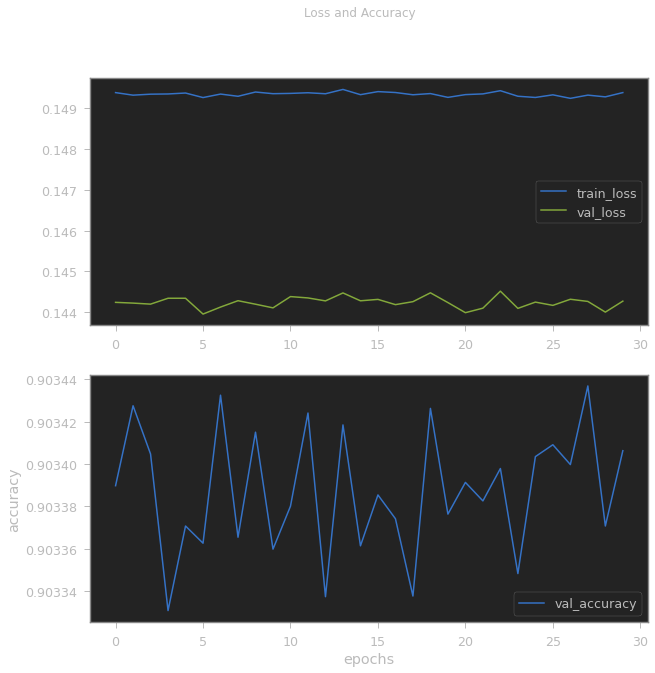

In [33]:
plot_loss_acc(history)

In [34]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [35]:
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None
CRITERION        = ComboLoss(**{'weights':{'bce':1, 'dice':3, 'focal':4}})

In [36]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [37]:
model = model.to(device)

In [38]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [39]:
history = train(model,optim,CRITERION,dl_train,dl_test,epochs=max_epochs, vis=False)

Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.38it/s]


Train_loss: 3.776147


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.70it/s]


Val_loss: 3.764944
Epoch: 1 TrainLoss from train func: 3.77615 ValidLoss from train func: 3.76494 ACC: 0.82891 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.35it/s]


Train_loss: 3.776280


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.61it/s]


Val_loss: 3.763982
Epoch: 2 TrainLoss from train func: 3.77628 ValidLoss from train func: 3.76398 ACC: 0.82856 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.38it/s]


Train_loss: 3.777296


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.54it/s]


Val_loss: 3.762277
Epoch: 3 TrainLoss from train func: 3.77730 ValidLoss from train func: 3.76228 ACC: 0.82896 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.44it/s]


Train_loss: 3.777077


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.39it/s]


Val_loss: 3.766741
Epoch: 4 TrainLoss from train func: 3.77708 ValidLoss from train func: 3.76674 ACC: 0.82813 F1: 0.084


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.15it/s]


Train_loss: 3.776804


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.51it/s]


Val_loss: 3.765082
Epoch: 5 TrainLoss from train func: 3.77680 ValidLoss from train func: 3.76508 ACC: 0.82817 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.28it/s]


Train_loss: 3.776262


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.32it/s]


Val_loss: 3.764200
Epoch: 6 TrainLoss from train func: 3.77626 ValidLoss from train func: 3.76420 ACC: 0.82846 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.25it/s]


Train_loss: 3.775298


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.43it/s]


Val_loss: 3.764012
Epoch: 7 TrainLoss from train func: 3.77530 ValidLoss from train func: 3.76401 ACC: 0.82882 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.23it/s]


Train_loss: 3.776602


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.37it/s]


Val_loss: 3.761665
Epoch: 8 TrainLoss from train func: 3.77660 ValidLoss from train func: 3.76166 ACC: 0.82879 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.25it/s]


Train_loss: 3.776953


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.28it/s]


Val_loss: 3.762772
Epoch: 9 TrainLoss from train func: 3.77695 ValidLoss from train func: 3.76277 ACC: 0.82877 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.23it/s]


Train_loss: 3.778030


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.39it/s]


Val_loss: 3.759550
Epoch: 10 TrainLoss from train func: 3.77803 ValidLoss from train func: 3.75955 ACC: 0.82894 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.30it/s]


Train_loss: 3.777065


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.48it/s]


Val_loss: 3.764990
Epoch: 11 TrainLoss from train func: 3.77706 ValidLoss from train func: 3.76499 ACC: 0.82871 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.30it/s]


Train_loss: 3.778248


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.41it/s]


Val_loss: 3.757479
Epoch: 12 TrainLoss from train func: 3.77825 ValidLoss from train func: 3.75748 ACC: 0.82929 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.29it/s]


Train_loss: 3.776272


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.43it/s]


Val_loss: 3.760625
Epoch: 13 TrainLoss from train func: 3.77627 ValidLoss from train func: 3.76062 ACC: 0.82900 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.25it/s]


Train_loss: 3.776159


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.47it/s]


Val_loss: 3.767315
Epoch: 14 TrainLoss from train func: 3.77616 ValidLoss from train func: 3.76731 ACC: 0.82840 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.22it/s]


Train_loss: 3.776651


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.38it/s]


Val_loss: 3.757785
Epoch: 15 TrainLoss from train func: 3.77665 ValidLoss from train func: 3.75778 ACC: 0.82931 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.23it/s]


Train_loss: 3.777538


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.31it/s]


Val_loss: 3.767092
Epoch: 16 TrainLoss from train func: 3.77754 ValidLoss from train func: 3.76709 ACC: 0.82856 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.24it/s]


Train_loss: 3.777011


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.41it/s]


Val_loss: 3.764525
Epoch: 17 TrainLoss from train func: 3.77701 ValidLoss from train func: 3.76453 ACC: 0.82812 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.25it/s]


Train_loss: 3.777110


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.33it/s]


Val_loss: 3.759504
Epoch: 18 TrainLoss from train func: 3.77711 ValidLoss from train func: 3.75950 ACC: 0.82898 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.26it/s]


Train_loss: 3.775989


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.44it/s]


Val_loss: 3.761465
Epoch: 19 TrainLoss from train func: 3.77599 ValidLoss from train func: 3.76147 ACC: 0.82843 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.28it/s]


Train_loss: 3.776653


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.38it/s]


Val_loss: 3.764159
Epoch: 20 TrainLoss from train func: 3.77665 ValidLoss from train func: 3.76416 ACC: 0.82828 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.31it/s]


Train_loss: 3.778436


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.30it/s]


Val_loss: 3.765900
Epoch: 21 TrainLoss from train func: 3.77844 ValidLoss from train func: 3.76590 ACC: 0.82833 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:25<00:00,  5.31it/s]


Train_loss: 3.776568


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.29it/s]


Val_loss: 3.764792
Epoch: 22 TrainLoss from train func: 3.77657 ValidLoss from train func: 3.76479 ACC: 0.82830 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.10it/s]


Train_loss: 3.776098


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.08it/s]


Val_loss: 3.762786
Epoch: 23 TrainLoss from train func: 3.77610 ValidLoss from train func: 3.76279 ACC: 0.82901 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.10it/s]


Train_loss: 3.776021


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.20it/s]


Val_loss: 3.763501
Epoch: 24 TrainLoss from train func: 3.77602 ValidLoss from train func: 3.76350 ACC: 0.82854 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.10it/s]


Train_loss: 3.776334


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.15it/s]


Val_loss: 3.768808
Epoch: 25 TrainLoss from train func: 3.77633 ValidLoss from train func: 3.76881 ACC: 0.82812 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.10it/s]


Train_loss: 3.776920


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.26it/s]


Val_loss: 3.767027
Epoch: 26 TrainLoss from train func: 3.77692 ValidLoss from train func: 3.76703 ACC: 0.82845 F1: 0.081


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.11it/s]


Train_loss: 3.777854


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.14it/s]


Val_loss: 3.761928
Epoch: 27 TrainLoss from train func: 3.77785 ValidLoss from train func: 3.76193 ACC: 0.82850 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.15it/s]


Train_loss: 3.777350


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.10it/s]


Val_loss: 3.759998
Epoch: 28 TrainLoss from train func: 3.77735 ValidLoss from train func: 3.76000 ACC: 0.82874 F1: 0.082


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.14it/s]


Train_loss: 3.777072


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.22it/s]


Val_loss: 3.768941
Epoch: 29 TrainLoss from train func: 3.77707 ValidLoss from train func: 3.76894 ACC: 0.82786 F1: 0.083


Iterating over train data: 100%|██████████████| 137/137 [00:26<00:00,  5.15it/s]


Train_loss: 3.776945


Iterating over evaluation data: 100%|███████████| 16/16 [00:03<00:00,  4.21it/s]

Val_loss: 3.763921
Epoch: 30 TrainLoss from train func: 3.77695 ValidLoss from train func: 3.76392 ACC: 0.82891 F1: 0.083


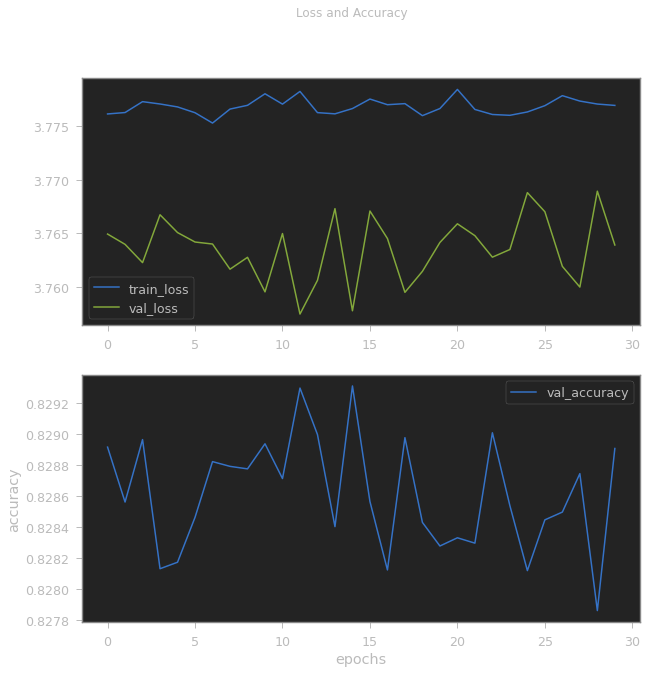

In [40]:
plot_loss_acc(history)